# Data Collection

## Installing Libraries

In [69]:
import pandas as pd
AA02_data = pd.read_csv(r"equity-post-HCT-survival-predictions\train.csv")

In [70]:
AA02_data['efs_time'].head(100)

0      42.356
1       4.672
2      19.793
3     102.349
4      16.223
       ...   
95      3.668
96      9.987
97     39.402
98     36.575
99     60.831
Name: efs_time, Length: 100, dtype: float64

## Checking structure of Data

In [4]:
AA02_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [5]:
AA02_data.head(3)

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793


# Data Preprocessing

## Data Sampling

In [6]:
AA02_sample_data = AA02_data.copy()

### Supporting Fucntions

In [7]:
def AA02_check_unique_values(dataframe):
    """
    Calculate the number of unique values, total values,
    and percentage of unique values for each column in the DataFrame.

    Args:
        dataframe (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A summary DataFrame with unique value statistics.
    """
    # Calculate unique values, total values, and percentage of unique values
    unique_counts = dataframe.nunique()
    total_counts = dataframe.count()
    percentages = (unique_counts / total_counts) * 100

    # Combine the results into a DataFrame for better AA02_display
    summary_AA02_df = pd.DataFrame({
        'Unique Values': unique_counts,
        'Total Values': total_counts,
        'Percentage (%)': percentages
    })

    return summary_AA02_df
    
import pandas as pd

# Function to calculate missing data information
def AA02_missing_data_info(AA02_sample_data):
    # Calculate missing count and percentage
    AA02_missing_count = AA02_sample_data.isnull().sum()
    AA02_missing_percentage = (AA02_missing_count / len(AA02_sample_data)) * 100

    # Create a DataFrame with missing data information
    AA02_missing_info = pd.DataFrame({
        'AA02_Variable': AA02_sample_data.columns,
        'AA02_Missing_Count': AA02_missing_count.values,
        'AA02_Missing_Percentage': AA02_missing_percentage.values
    }).reset_index(drop=True)

    # Format the percentage column
    AA02_missing_info['AA02_Missing_Percentage'] = AA02_missing_info['AA02_Missing_Percentage'].round(2).astype(str) + '%'

    return AA02_missing_info

import pandas as pd
from IPython.display import display

def display_full_dataframe(df):
    # Set display options for max columns and rows
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    # Display the DataFrame
    display(df)

    # Reset options to defaults after displaying
    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')

## Feature engineering

### Supporting Function

In [8]:
import numpy as np
from sklearn.cluster import KMeans

def feature_engineering(AA02_sample_data):
    """
    Perform feature engineering on the dataset.

    Parameters:
    AA02_sample_data (pd.DataFrame): The dataset to which feature engineering will be applied.

    Returns:
    pd.DataFrame: The dataset with additional engineered features.
    """
    # 1. Recipient-Donor Age Ratio
    AA02_sample_data['AA02_recipient_donor_age_ratio'] = (
        AA02_sample_data['age_at_hct'] / (AA02_sample_data['donor_age'] + 1e-6)
        if not AA02_sample_data[['age_at_hct', 'donor_age']].isnull().any(axis=1).any() else np.nan
    )

    # 2. Comorbidity-Adjusted Age
    AA02_sample_data['AA02_comorbidity_adjusted_age'] = (
        AA02_sample_data['age_at_hct'] + (AA02_sample_data['comorbidity_score'] * 5)
        if not AA02_sample_data[['age_at_hct', 'comorbidity_score']].isnull().any(axis=1).any() else np.nan
    )

    # 3. Functional Health Interaction
    AA02_sample_data['AA02_functional_health_score'] = (
        AA02_sample_data['karnofsky_score'] * (1 - AA02_sample_data['comorbidity_score'])
        if not AA02_sample_data[['karnofsky_score', 'comorbidity_score']].isnull().any(axis=1).any() else np.nan
    )

    # 4. Risk-Adjusted HLA Matching
    AA02_sample_data['AA02_hla_risk_adjusted'] = (
        AA02_sample_data[['hla_match_c_high', 'hla_match_a_high', 'hla_match_b_high']].mean(axis=1) * (1 - AA02_sample_data['comorbidity_score'])
        if not AA02_sample_data[['hla_match_c_high', 'hla_match_a_high', 'hla_match_b_high', 'comorbidity_score']].isnull().any(axis=1).any() else np.nan
    )

    # 5. Recipient Gender and Donor Gender Match
    AA02_sample_data['AA02_gender_mismatch'] = (
        (AA02_sample_data['sex_match'] != 'Yes').astype(int)
        if not AA02_sample_data['sex_match'].isnull().any() else np.nan
    )

    # 6. Donor-Recipient Ethnic Compatibility
    AA02_sample_data['AA02_ethnic_mismatch'] = (
        AA02_sample_data['ethnicity'] != AA02_sample_data['race_group']
        if not AA02_sample_data[['ethnicity', 'race_group']].isnull().any(axis=1).any() else np.nan
    )

    # 8. Age-Health Interactions
    AA02_sample_data['AA02_age_health_interaction'] = (
        AA02_sample_data['age_at_hct'] * (1 - AA02_sample_data['comorbidity_score'])
        if not AA02_sample_data[['age_at_hct', 'comorbidity_score']].isnull().any(axis=1).any() else np.nan
    )

    # 9. Time-Sensitive Variables
    AA02_sample_data['AA02_relative_age'] = (
        AA02_sample_data['year_hct'] - AA02_sample_data['age_at_hct']
        if not AA02_sample_data[['year_hct', 'age_at_hct']].isnull().any(axis=1).any() else np.nan
    )

    # 10. Frequency Encoding for Race Group
    AA02_sample_data['AA02_race_frequency'] = (
        AA02_sample_data['race_group'].map(
            AA02_sample_data['race_group'].value_counts(normalize=True)
        ) if not AA02_sample_data['race_group'].isnull().any() else np.nan
    )

    # 11. Statistical Aggregations
    AA02_sample_data['AA02_avg_karnofsky_by_ethnicity'] = (
        AA02_sample_data.groupby('ethnicity')['karnofsky_score'].transform('mean')
        if not AA02_sample_data[['ethnicity', 'karnofsky_score']].isnull().any(axis=1).any() else np.nan
    )

    # 12. Composite Risk Score
    AA02_sample_data['AA02_composite_risk_score'] = (
        AA02_sample_data['comorbidity_score'] +
        (AA02_sample_data['age_at_hct'] / 10) +
        (1 - AA02_sample_data['karnofsky_score'] / 100)
        if not AA02_sample_data[['comorbidity_score', 'age_at_hct', 'karnofsky_score']].isnull().any(axis=1).any() else np.nan
    )

    # 13. Polynomial Transformations
    AA02_sample_data['AA02_age_squared'] = (
        AA02_sample_data['age_at_hct'] ** 2
        if not AA02_sample_data['age_at_hct'].isnull().any() else np.nan
    )

    # 14. Health Status Summaries
    health_conditions = ['renal_issue', 'diabetes', 'psych_disturb']
    AA02_sample_data['AA02_health_burden'] = (
        AA02_sample_data[health_conditions].apply(lambda row: row.eq('Yes').sum(), axis=1)
        if not AA02_sample_data[health_conditions].isnull().any(axis=1).any() else np.nan
    )

    # 15. Clustering Features
    kmeans = KMeans(n_clusters=5, random_state=42)
    AA02_sample_data['AA02_hla_cluster'] = (
        kmeans.fit_predict(
            AA02_sample_data[['hla_match_c_high', 'hla_match_a_high', 'hla_match_b_high']]
        ) if not AA02_sample_data[['hla_match_c_high', 'hla_match_a_high', 'hla_match_b_high']].isnull().any(axis=1).any() else np.nan
    )

    # 16. Missing Data Indicators
    AA02_sample_data['AA02_missing_hla_match'] = AA02_sample_data['hla_match_c_high'].isnull().astype(int)

    # 18. Temporal Features
    AA02_sample_data['AA02_yearly_trend'] = (
        AA02_sample_data['year_hct'] % 10
        if not AA02_sample_data['year_hct'].isnull().any() else np.nan
    )
    AA02_sample_data['AA02_decade'] = (
        (AA02_sample_data['year_hct'] // 10) * 10
        if not AA02_sample_data['year_hct'].isnull().any() else np.nan
    )

    return AA02_sample_data


### Function call

In [9]:
AA02_sample_data = feature_engineering(AA02_sample_data)

## Categorizing Variables

In [10]:
# Load the CSV file
file_path = r'equity-post-HCT-survival-predictions\data_dictionary.csv'  # Update with your actual file path
data = pd.read_csv(file_path)

# Extract all variables
AA02_columns = data['variable'].tolist()

In [11]:
AA02_columns.extend([
    'AA02_gender_mismatch', 'AA02_ethnic_mismatch', 'AA02_hla_cluster', 'AA02_missing_hla_match', 'AA02_yearly_trend',
    'AA02_decade', 'AA02_health_burden', 'AA02_recipient_donor_age_ratio', 'AA02_comorbidity_adjusted_age',
    'AA02_functional_health_score', 'AA02_hla_risk_adjusted', 'AA02_age_health_interaction',
    'AA02_relative_age', 'AA02_race_frequency', 'AA02_avg_karnofsky_by_ethnicity', 'AA02_composite_risk_score',
    'AA02_age_squared'
])

In [12]:
# Extract data type from data_dictionary's df
data['type'] = data['type'].str.strip().str.lower()

# Separate categorical and numerical columns
AA02_categorical_columns = data[data['type'] == 'categorical']['variable'].tolist()
AA02_non_categorical_columns = data[data['type'] == 'numerical']['variable'].tolist()

In [13]:
AA02_categorical_columns.extend([
    'AA02_gender_mismatch', 'AA02_ethnic_mismatch', 'AA02_hla_cluster', 'AA02_missing_hla_match',
    'AA02_yearly_trend', 'AA02_decade', 'AA02_health_burden'
])
AA02_non_categorical_columns.extend([
    'AA02_recipient_donor_age_ratio', 'AA02_comorbidity_adjusted_age', 'AA02_functional_health_score',
    'AA02_hla_risk_adjusted', 'AA02_age_health_interaction', 'AA02_relative_age',
    'AA02_race_frequency', 'AA02_avg_karnofsky_by_ethnicity', 'AA02_composite_risk_score',
    'AA02_age_squared'
])

In [14]:
## Divde Categorical variable into two parts ordinal & nominal
AA02_categorical_ordinal_columns = []
AA02_categorical_nominal_columns = AA02_categorical_columns

In [15]:
list_1_high_relevance = [
    'efs_time', 'AA02_recipient_donor_age_ratio', 'AA02_comorbidity_adjusted_age',
    'AA02_functional_health_score', 'AA02_hla_risk_adjusted', 'karnofsky_score',
    'comorbidity_score', 'hla_match_c_high', 'hla_match_a_high', 'hla_match_b_high',
    'hla_match_dqb1_high', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low'
]
list_2_moderate_relevance = [
    'age_at_hct', 'donor_age', 'dri_score', 'conditioning_intensity', 
    'hla_high_res_6', 'hla_high_res_8', 'hla_high_res_10', 'hla_low_res_6',
    'hla_low_res_8', 'hla_low_res_10', 'AA02_age_health_interaction', 
    'AA02_composite_risk_score', 'AA02_avg_karnofsky_by_ethnicity'
]

list_2_moderate_relevance.extend([
    'tbi_status', 'cmv_status', 'tce_imm_match', 'hla_nmdp_6',
    'hla_match_b_low', 'hla_match_a_low', 'hla_match_drb1_high'
])


list_3_context_dependent = [
    'graft_type', 'sex_match', 'race_group', 'ethnicity', 'AA02_gender_mismatch',
    'AA02_ethnic_mismatch', 'rituximab', 'gvhd_proph', 'prod_type',
    'cyto_score', 'cyto_score_detail', 'prim_disease_hct'
]

list_3_context_dependent.extend([
    'mrd_hct', 'in_vivo_tcd', 'tce_match', 'tce_div_match',
    'donor_related', 'melphalan_dose'
])

list_4_limited_relevance = [
    'psych_disturb', 'diabetes', 'renal_issue', 'pulm_severe', 'hepatic_severe',
    'hepatic_mild', 'arrhythmia', 'vent_hist', 'prior_tumor', 'obesity',
    'rheum_issue', 'peptic_ulcer', 'cardiac', 'pulm_moderate'
]
list_5_temporal_and_others = [
    'year_hct', 'AA02_relative_age', 'AA02_race_frequency', 'AA02_age_squared',
    'AA02_health_burden', 'AA02_hla_cluster', 'AA02_missing_hla_match',
    'AA02_yearly_trend', 'AA02_decade'
]

list_6_uncategorized = [
    'ID',  # Unique identifier, likely not predictive but can be useful for tracking
    'efs'  # Binary target variable for survival status (useful for classification but not ranking directly)
]

In [16]:
AA02_y = ['efs', 'efs_time']  # Target variable

## Imputation

### Checking Missing Percentage

#### Variable

In [17]:
import pandas as pd

# Function to calculate missing data information
def AA02_missing_data_info(AA02_sample_data):
    # Calculate missing count and percentage
    AA02_missing_count = AA02_sample_data.isnull().sum()
    AA02_missing_percentage = (AA02_missing_count / len(AA02_sample_data)) * 100

    # Create a DataFrame with missing data information
    AA02_missing_info = pd.DataFrame({
        'AA02_Variable': AA02_sample_data.columns,
        'AA02_Missing_Count': AA02_missing_count.values,
        'AA02_Missing_Percentage': AA02_missing_percentage.values
    }).reset_index(drop=True)

    # Format the percentage column
    AA02_missing_info['AA02_Missing_Percentage'] = AA02_missing_info['AA02_Missing_Percentage'].round(2).astype(str) + '%'

    return AA02_missing_info

In [18]:
display_full_dataframe(AA02_missing_data_info(AA02_sample_data))

,AA02_Variable,AA02_Missing_Count,AA02_Missing_Percentage
0,ID,0,0.0%
1,dri_score,154,0.53%
2,psych_disturb,2062,7.16%
3,cyto_score,8068,28.01%
4,diabetes,2119,7.36%
5,hla_match_c_high,4620,16.04%
6,hla_high_res_8,5829,20.24%
7,tbi_status,0,0.0%
8,arrhythmia,2202,7.65%
9,hla_low_res_6,3270,11.35%


##### Supporting Fucntion

In [19]:
import pandas as pd

# Function to omit variables with more than a threshold of missing values and log omitted variables
def AA02_clean_data_with_logging(
    AA02_sample_data,
    AA02_categorical_columns,
    AA02_non_categorical_columns,
    AA02_columns,
    missing_threshold=50
):
    # Calculate missing percentage for each variable
    AA02_missing_percentage = (AA02_sample_data.isnull().sum() / len(AA02_sample_data)) * 100

    # Identify variables to omit (missing percentage > threshold)
    variables_to_omit = AA02_missing_percentage[AA02_missing_percentage > missing_threshold]

    # Create a DataFrame for omitted variables
    omitted_info = []
    for variable, percentage in variables_to_omit.items():
        if variable in AA02_categorical_columns:
            source = "AA02_categorical_columns"
        elif variable in AA02_non_categorical_columns:
            source = "AA02_non_categorical_columns"
        elif variable in AA02_columns:
            source = "AA02_columns"
        else:
            source = "Unknown"

        omitted_info.append({
            "Variable": variable,
            "Missing_Percentage": round(percentage, 2),
            "Omitted_From": source
        })

    # Convert omitted info to DataFrame
    AA02_omitted_df = pd.DataFrame(omitted_info)

    # Identify variables to keep
    variables_to_keep = AA02_missing_percentage[AA02_missing_percentage <= missing_threshold].index.tolist()

    # Filter the dataset
    AA02_sample_data_cleaned = AA02_sample_data[variables_to_keep]

    # Update the lists (only keep variables that are not omitted)
    AA02_columns[:] = [col for col in AA02_columns if col in variables_to_keep]
    AA02_categorical_columns[:] = [col for col in AA02_categorical_columns if col in variables_to_keep]
    AA02_non_categorical_columns[:] = [col for col in AA02_non_categorical_columns if col in variables_to_keep]

    # Print the DataFrame of omitted variables
    print("Variables Omitted Due to Missing Values (> {}%):".format(missing_threshold))
    display_full_dataframe(AA02_omitted_df)

    return AA02_sample_data_cleaned


##### Function Call

In [20]:
AA02_sample_data_cleaned = AA02_clean_data_with_logging(
    AA02_sample_data,
    AA02_categorical_columns,
    AA02_non_categorical_columns,
    AA02_columns,
    missing_threshold=99
)

Variables Omitted Due to Missing Values (> 99%):


,Variable,Missing_Percentage,Omitted_From
0,AA02_recipient_donor_age_ratio,100.0,AA02_non_categorical_columns
1,AA02_comorbidity_adjusted_age,100.0,AA02_non_categorical_columns
2,AA02_functional_health_score,100.0,AA02_non_categorical_columns
3,AA02_hla_risk_adjusted,100.0,AA02_non_categorical_columns
4,AA02_gender_mismatch,100.0,AA02_categorical_columns
5,AA02_ethnic_mismatch,100.0,AA02_categorical_columns
6,AA02_age_health_interaction,100.0,AA02_non_categorical_columns
7,AA02_avg_karnofsky_by_ethnicity,100.0,AA02_non_categorical_columns
8,AA02_composite_risk_score,100.0,AA02_non_categorical_columns
9,AA02_health_burden,100.0,AA02_categorical_columns


In [21]:
# Dropping variables from data frame
# Select variables from AA02_sample_data that are present in AA02_columns
AA02_sample_data_dropped_variable = AA02_sample_data[AA02_columns]

# Display the resulting dataset
AA02_sample_data_dropped_variable.head(3)

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,pulm_moderate,hla_low_res_10,efs,efs_time,AA02_missing_hla_match,AA02_yearly_trend,AA02_decade,AA02_relative_age,AA02_race_frequency,AA02_age_squared
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,...,No,10.0,0.0,42.356,1,6,2010,2006.058,0.168229,98.843364
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,...,Yes,10.0,1.0,4.672,0,8,2000,1964.295,0.167778,1910.127025
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,No,10.0,0.0,19.793,0,9,2010,1985.003,0.168229,1155.796009


#### Records

In [22]:
import pandas as pd

def AA02_remove_records_with_missing_values(AA02_sample_data_dropped_variable, percentage):
    """
    This function removes records from the DataFrame where the percentage of missing values 
    exceeds the specified threshold.

    Parameters:
        AA02_sample_data_dropped_variable (pd.DataFrame): The input DataFrame.
        percentage (float): The threshold percentage of missing values.

    Returns:
        pd.DataFrame: Modified DataFrame with records removed.
    """
    # Calculate the threshold for missing values based on the given percentage
    threshold = (percentage / 100) * AA02_sample_data_dropped_variable.shape[1]

    # Identify records with missing values exceeding the threshold
    AA02_records_with_excessive_missing = AA02_sample_data_dropped_variable[AA02_sample_data_dropped_variable.isnull().sum(axis=1) > threshold]

    # Print the records with excessive missing values
    print("Records with more than", percentage, "% missing values:")
    AA02_records_with_excessive_missing

    # Remove those records from the original DataFrame
    AA02_sample_data_dropped_records = AA02_sample_data_dropped_variable.drop(index=AA02_records_with_excessive_missing.index)

    # Return the modified DataFrame
    return AA02_sample_data_dropped_records, AA02_records_with_excessive_missing


AA02_sample_data_dropped_records, AA02_records_with_excessive_missing = AA02_remove_records_with_missing_values(AA02_sample_data_dropped_variable.copy(), 50)
AA02_records_with_excessive_missing


Records with more than 50 % missing values:


,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,pulm_moderate,hla_low_res_10,efs,efs_time,AA02_missing_hla_match,AA02_yearly_trend,AA02_decade,AA02_relative_age,AA02_race_frequency,AA02_age_squared
109,Low,NaN,NaN,NaN,NaN,NaN,No TBI,NaN,NaN,Peripheral blood,...,NaN,NaN,1.0,7.669,1,3,2010,1955.660,0.166319,3287.875600
1061,High,NaN,Poor,NaN,NaN,NaN,"TBI +- Other, <=cGy",NaN,NaN,Peripheral blood,...,NaN,NaN,1.0,3.896,1,8,2010,1951.133,0.163438,4471.195689
1161,TBD cytogenetics,NaN,NaN,NaN,NaN,NaN,No TBI,NaN,NaN,Peripheral blood,...,NaN,NaN,0.0,35.563,1,8,2010,2010.614,0.167743,54.552996
1346,Intermediate,NaN,Intermediate,NaN,NaN,NaN,No TBI,NaN,NaN,Peripheral blood,...,NaN,NaN,1.0,6.047,1,8,2010,1967.595,0.163438,2540.664025
1382,Intermediate,NaN,Favorable,NaN,NaN,NaN,No TBI,NaN,NaN,Peripheral blood,...,NaN,NaN,0.0,12.327,1,9,2010,1959.504,0.163438,3539.774016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26280,Intermediate,NaN,Intermediate,NaN,NaN,NaN,No TBI,NaN,NaN,Peripheral blood,...,NaN,NaN,1.0,4.623,1,8,2010,1980.227,0.166319,1426.799529
26302,NaN,NaN,Poor,NaN,NaN,NaN,No TBI,NaN,NaN,Bone marrow,...,NaN,NaN,0.0,37.045,1,8,2010,1957.668,0.167778,3639.950224
26716,Low,NaN,Poor,NaN,NaN,NaN,No TBI,NaN,NaN,Peripheral blood,...,NaN,NaN,1.0,7.525,1,8,2010,1960.800,0.167743,3271.840000
27584,Intermediate,NaN,Intermediate,NaN,NaN,NaN,No TBI,NaN,NaN,Peripheral blood,...,NaN,NaN,1.0,6.185,1,9,2010,1968.510,0.163438,2549.240100


### Categorical Imputation

In [23]:
from sklearn.impute import SimpleImputer # type: ignore

AA02_sample_data_imputed = AA02_sample_data_dropped_variable.copy()

# Initialize SimpleImputer with most_frequent strategy
AA02_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
AA02_sample_data_imputed[AA02_categorical_columns] = AA02_imputer.fit_transform(AA02_sample_data_imputed[AA02_categorical_columns])

### Non Categorical Imputation

#### Supporting Function

In [24]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer # type: ignore

def AA02_impute_columns_with_mean_or_median(AA02_df, columns):
    """
    Impute missing values in specified columns with mean or median based on significant difference.

    Parameters:
    AA02_df (pd.DataFrame): The dataframe to impute.
    columns (list): List of column names to impute.

    Returns:
    pd.DataFrame: The updated dataframe after imputation.
    pd.DataFrame: A dataframe with imputation details for each column.
    """
    imputation_details = []

    for col in columns:
        # Ensure column is numeric
        AA02_df[col] = pd.to_numeric(AA02_df[col], errors='coerce')

        # Replace invalid values with NaN
        AA02_df[col].replace([np.inf, -np.inf], np.nan, inplace=True)

        # Skip if column has no missing values
        if AA02_df[col].isnull().sum() == 0:
            imputation_details.append({
                'Variable': col,
                'Imputation Method': 'None (No Missing Values)',
                'Significant Difference': 0,
                'Percentage Difference': 0.00
            })
            continue

        # Calculate mean and median
        AA02_col_mean = AA02_df[col].mean()
        AA02_col_median = AA02_df[col].median()

        # Calculate percentage difference
        percentage_diff = abs(AA02_col_mean - AA02_col_median) / max(abs(AA02_col_mean), abs(AA02_col_median)) * 100
        significant_diff = int(percentage_diff > 10)  # Binary: 1 if significant, 0 otherwise

        # Choose strategy based on significant difference
        if significant_diff:
            imputation_method = 'Median'
            AA02_imputer = SimpleImputer(strategy='median')
        else:
            imputation_method = 'Mean'
            AA02_imputer = SimpleImputer(strategy='mean')

        # Apply the AA02_imputer
        AA02_df[[col]] = AA02_imputer.fit_transform(AA02_df[[col]])

        # Append details to the list
        imputation_details.append({
            'Variable': col,
            'Imputation Method': imputation_method,
            'Significant Difference': significant_diff,
            'Percentage Difference': round(percentage_diff, 2)
        })

    # Create a dataframe with imputation details
    imputation_details_df = pd.DataFrame(imputation_details)

    return AA02_df, imputation_details_df



#### Function call

In [25]:
AA02_sample_data_imputed, imputation_details = AA02_impute_columns_with_mean_or_median(AA02_sample_data_imputed, AA02_non_categorical_columns)
imputation_details

,Variable,Imputation Method,Significant Difference,Percentage Difference
0,hla_match_c_high,Median,1,11.77
1,hla_high_res_8,Median,1,14.04
2,hla_low_res_6,Median,1,14.28
3,hla_high_res_6,Median,1,14.85
4,hla_high_res_10,Median,1,13.83
5,hla_match_dqb1_high,Median,1,13.16
6,hla_nmdp_6,Median,1,13.99
7,hla_match_c_low,Median,1,12.11
8,hla_match_drb1_low,Median,1,14.24
9,hla_match_dqb1_low,Median,1,11.31


### Verify Missing Percetage = 0

In [26]:
# AA02_missing_data_info(AA02_sample_data_imputed)

## Covert to numeric if possible

### Supporting Function

In [27]:
import pandas as pd
import numpy as np

def convert_to_numeric(dataframe):
    """
    Converts all columns in the DataFrame into numeric types where possible.
    - Strings will be converted to numeric if feasible.
    - True/False (case insensitive) will be converted to 1 and 0.
    - If a value cannot be converted to numeric, it will remain as is.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to convert.

    Returns:
        pd.DataFrame: A DataFrame with numeric conversions applied where possible.
    """
    def safe_convert(value):
        # Handle case-insensitive True/False
        if isinstance(value, str):
            if value.strip().lower() == 'true':
                return 1
            elif value.strip().lower() == 'false':
                return 0
        
        # Try to convert other values to numeric
        try:
            return pd.to_numeric(value, errors='raise')
        except:
            return value

    # Apply safe conversion to all elements in the DataFrame
    dataframe = dataframe.applymap(safe_convert)

    return dataframe

### Function call

In [28]:
# Example usage
AA02_sample_data_numeric = convert_to_numeric(AA02_sample_data_imputed)

## Numerical Encoding

### Total Nominal unique value

In [29]:
def AA02_check_unique_values(dataframe):
    """
    Checks and returns the number of unique values for each column in the DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame with column names and their unique value counts.
    """
    unique_values = dataframe.nunique()
    return pd.DataFrame({"Variable Name": unique_values.index, "Unique Values": unique_values.values})

# Example usage
unique_values_df = AA02_check_unique_values(AA02_sample_data_imputed[AA02_categorical_nominal_columns])
sum_unique_values = unique_values_df["Unique Values"].sum()

print("Sum of all unique values:", sum_unique_values)
display_full_dataframe(AA02_check_unique_values(AA02_sample_data_numeric[AA02_categorical_nominal_columns]))

Sum of all unique values: 178


,Variable Name,Unique Values
0,dri_score,11
1,psych_disturb,3
2,cyto_score,7
3,diabetes,3
4,tbi_status,8
5,arrhythmia,3
6,graft_type,2
7,vent_hist,2
8,renal_issue,3
9,pulm_severe,3


### Ordinal/Nominal Encoding

#### Supporting function

In [30]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import pandas as pd

def encode_categorical_columns(dataframe, ordinal_columns, nominal_columns, use_one_hot_for_nominal=False, ordinal_categories=None):
    """
    Encodes categorical columns in the dataframe using either OrdinalEncoder or OneHotEncoder for nominal columns
    and OrdinalEncoder for ordinal columns.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to encode.
        ordinal_columns (list): List of ordinal column names to encode.
        nominal_columns (list): List of nominal column names to encode.
        use_one_hot_for_nominal (bool): If True, use OneHotEncoder for nominal columns. Otherwise, use OrdinalEncoder.
        ordinal_categories (list of lists): The order of categories for ordinal columns. Pass None if not applicable.

    Returns:
        pd.DataFrame: DataFrame with encoded categorical columns.
    """
    # Make a copy of the DataFrame
    dataframe_encoded = dataframe.copy()

    # Initialize OrdinalEncoder for ordinal columns with specified order
    if ordinal_categories:
        ordinal_encoder_ordinal = OrdinalEncoder(categories=ordinal_categories)
    else:
        ordinal_encoder_ordinal = OrdinalEncoder()

    # Encode ordinal columns
    if ordinal_columns:
        dataframe_encoded[ordinal_columns] = ordinal_encoder_ordinal.fit_transform(
            dataframe_encoded[ordinal_columns].astype(str)
        )

    # Encode nominal columns
    if use_one_hot_for_nominal:
        # Exclude numeric columns from one-hot encoding
        nominal_columns_to_encode = [col for col in nominal_columns if not pd.api.types.is_numeric_dtype(dataframe[col])]
        if nominal_columns_to_encode:
            one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
            encoded_nominal_columns = one_hot_encoder.fit_transform(dataframe_encoded[nominal_columns_to_encode].astype(str))
            encoded_nominal_df = pd.DataFrame(
                encoded_nominal_columns,
                columns=one_hot_encoder.get_feature_names_out(nominal_columns_to_encode),
                index=dataframe_encoded.index
            )
            dataframe_encoded = dataframe_encoded.drop(nominal_columns_to_encode, axis=1)
            dataframe_encoded = pd.concat([dataframe_encoded, encoded_nominal_df], axis=1)
    else:
        ordinal_encoder_nominal = OrdinalEncoder()
        dataframe_encoded[nominal_columns] = ordinal_encoder_nominal.fit_transform(
            dataframe_encoded[nominal_columns].astype(str)
        )

    return dataframe_encoded

# Example usage
AA02_ordinal_categories = [#['low', 'mid', 'high'] #low is 0 mid is 1 hight is 2
]


#### Function Call

In [31]:
AA02_sample_data_ordinally_encoded = encode_categorical_columns(
    dataframe=AA02_sample_data_numeric,
    ordinal_columns=AA02_categorical_ordinal_columns,
    nominal_columns=AA02_categorical_nominal_columns,
    use_one_hot_for_nominal=True,  # Set to False to use OrdinalEncoder for nominal columns
    ordinal_categories=AA02_ordinal_categories
)
# pd.set_option('display.max_columns', None)
# display(AA02_sample_data_ordinally_encoded)

## Transformation

#### Supporting Function

In [32]:
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer # type: ignore
import pandas as pd

# Function to handle transformations based on distribution characteristics
def apply_transformations(AA02_sample_data, columns):
    # Initialize a list to store transformation logs
    AA02_transformation_logs = []

    for column in columns:
        # Compute AA02_skewness and AA02_kurtosis
        AA02_skewness = AA02_sample_data[column].skew()
        AA02_kurtosis = AA02_sample_data[column].kurt()
        AA02_action = "None"  # Default AA02_action

        # Handle Right Skew (Positive Skew)
        if AA02_skewness > 1:
            AA02_action = "Log Transformation"
            AA02_sample_data[column] = np.log1p(AA02_sample_data[column])

        # Handle Left Skew (Negative Skew)
        elif AA02_skewness < -1:
            AA02_action = "Reflect and Log Transformation"
            AA02_sample_data[column] = np.log1p(AA02_sample_data[column].max() - AA02_sample_data[column])

        # Handle High Kurtosis (Heavy Tails)
        if AA02_kurtosis > 3:
            try:
                AA02_action = "Box-Cox Transformation"
                AA02_sample_data[column], _ = boxcox(AA02_sample_data[column].clip(lower=1))
            except ValueError:
                AA02_action = "Box-Cox Failed, Applied Yeo-Johnson"
                transformer = PowerTransformer(method='yeo-johnson')
                AA02_sample_data[column] = transformer.fit_transform(AA02_sample_data[[column]])

        # Handle Low Kurtosis (Light Tails)
        elif AA02_kurtosis < 3 and AA02_action == "None":
            AA02_action = "Yeo-Johnson Transformation"
            transformer = PowerTransformer(method='yeo-johnson')
            AA02_sample_data[column] = transformer.fit_transform(AA02_sample_data[[column]])

        AA02_skewness_after_transformation = AA02_sample_data[column].skew()
        AA02_kurtosis_after_transformation = AA02_sample_data[column].kurt()

        # Append the log entry
        AA02_transformation_logs.append({
            'Column Name': column,
            'Skewness Before Transformation': AA02_skewness,
            'Kurtosis Before Transformationv': AA02_kurtosis,
            'Action Taken': AA02_action,
            'Skewness After Transformation': AA02_skewness_after_transformation,
            'Kurtosis After Transformationv': AA02_kurtosis_after_transformation
        })

    # Create a DataFrame for transformation logs
    transformation_log_AA02_df = pd.DataFrame(AA02_transformation_logs)
    return AA02_sample_data, transformation_log_AA02_df

#### Function Call

In [33]:
# Example usage with AA02_sample_data_encoded
AA02_sample_data_encoded = AA02_sample_data_ordinally_encoded.copy()
AA02_sample_data_transformed, AA02_transformation_logs = apply_transformations(AA02_sample_data_encoded, AA02_non_categorical_columns)

# AA02_display the transformation log DataFrame
# print("Transformation Log:")
# AA02_transformation_logs

In [34]:
# Code for AA02_displaying transformed datset
AA02_sample_data_transformed.head(5)

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,tce_div_match_GvH non-permissive,tce_div_match_HvG non-permissive,tce_div_match_Permissive mismatched,donor_related_Related,donor_related_Unrelated,"melphalan_dose_N/A, Mel not given",cardiac_Not done,cardiac_Yes,pulm_moderate_Not done,pulm_moderate_Yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scaling

#### Supporting function

In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_dataframe(AA02_df,AA02_y_columns, method='standard'):
    """
    Scales numeric columns of the input DataFrame, excluding binary columns.

    Parameters:
        AA02_df (pd.DataFrame): Input DataFrame to scale.
        method (str): Scaling method, either 'standard' (default) for StandardScaler or 'minmax' for MinMaxScaler.

    Returns:
        pd.DataFrame: Scaled DataFrame with the same column names as the input.
    """
    if not isinstance(AA02_df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    # Select numeric columns only
    AA02_numeric_cols = AA02_df.select_dtypes(include=['float64', 'int64']).columns

    # Exclude binary columns (those with only two unique values)
    AA02_non_binary_cols = [col for col in AA02_numeric_cols if AA02_df[col].nunique() > 2]

    AA02_non_binary_cols = [
    var for var in AA02_non_binary_cols if var not in AA02_y_columns
]

    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid method. Use 'standard' or 'minmax'.")

    # Scale non-binary numeric columns
    AA02_df_scaled = AA02_df.copy()
    AA02_df_scaled[AA02_non_binary_cols] = scaler.fit_transform(AA02_df[AA02_non_binary_cols])

    return AA02_df_scaled



#### Function Call

In [36]:
AA02_sample_data_scaled =  AA02_sample_data_transformed.copy()
AA02_sample_data_scaled = scale_dataframe(AA02_sample_data_scaled, AA02_y)

# Machine Learning

## Dependent/Independent variables

### Supporting Function

In [37]:
def prepare_data(AA02_y_vars, AA02_cat_vars, AA02_non_cat_vars):
    """
    Prepares the data by calculating the feature set (AA02_x) while excluding dependent variables.

    Args:
    - AA02_y_vars: A list of dependent variable names (can handle multiple dependent variables).
    - AA02_cat_vars: A list of categorical variable names.
    - AA02_non_cat_vars: A list of non-categorical variable names.

    Returns:
    - AA02_y_vars: A list of dependent variable names.
    - AA02_x: A list of feature variable names, excluding dependent variables.
    """
    # Combine categorical and non-categorical variable lists
    AA02_all_vars = AA02_cat_vars + AA02_non_cat_vars

    # Ensure `AA02_y_vars` is a list for consistency
    if isinstance(AA02_y_vars, str):
        AA02_y_vars = [AA02_y_vars]

    # Calculate the feature set (x) as the difference between AA02_all_vars and y_vars
    AA02_x = [AA02_var for AA02_var in AA02_all_vars if AA02_var not in AA02_y_vars]

    return AA02_y_vars, AA02_x

### Function Call

In [38]:
AA02_y = ['efs', 'efs_time']

AA02_y_columns, AA02_x_columns = prepare_data(AA02_y, AA02_sample_data_scaled.columns.tolist(), [])

print("Target (y):", AA02_y_columns)
# print("Feature Set (x):", AA02_x_columns)

Target (y): ['efs', 'efs_time']


## Train Test Split

In [39]:
from sklearn.model_selection import train_test_split

AA02_sample_data_train_test_split = AA02_sample_data_scaled.copy()

# Extract the target columns (multi-output targets)
AA02_y_data = AA02_sample_data_train_test_split[AA02_y_columns]  # AA02_y_columns should be a list like ['efs', 'efs_time']

# Extract the features (as DataFrame)
AA02_x_data = AA02_sample_data_train_test_split[AA02_x_columns]  # AA02_x_columns is the list of feature column names

# Perform the train-test split
AA02_x_train, AA02_x_test, AA02_y_train, AA02_y_test = train_test_split(
    AA02_x_data, AA02_y_data, test_size=0.1, random_state=55002, stratify=AA02_y_data['efs']  # Stratify by 'efs'
)

## Factor Analysis

In [40]:
# Compute correlation matrix
correlation_matrix = AA02_x_train.corr()

# Identify perfect correlations (1 or -1) and exclude self-correlation
perfect_corr = correlation_matrix.where(
    (correlation_matrix == 1) | (correlation_matrix == -1)
).stack()

# Filter out self-correlations
perfect_corr = perfect_corr[perfect_corr.index.get_level_values(0) != perfect_corr.index.get_level_values(1)]

# Convert to a DataFrame for better readability
perfect_corr_df = perfect_corr.reset_index()
perfect_corr_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Print the result
display_full_dataframe(perfect_corr_df)


,Variable 1,Variable 2,Correlation


In [41]:
import pandas as pd
from factor_analyzer import FactorAnalyzer

# Check the correlation matrix
correlation_matrix = AA02_x_train.corr()

# Perform factor analysis
fa = FactorAnalyzer(n_factors=5, rotation="varimax")  # Adjust 'n_factors' as needed
fa.fit(AA02_x_train)

# Get eigenvalues to decide the number of factors to retain
eigenvalues, _ = fa.get_eigenvalues()
# print("Eigenvalues:\n", eigenvalues)

# Factor loadings
factor_loadings = pd.DataFrame(fa.loadings_, index=AA02_x_train.columns)
# print("Factor Loadings:\n", factor_loadings)

In [42]:
# Select important variables (e.g., variables with loadings > 0.5)
important_variables = factor_loadings[(factor_loadings.abs() > 0.0).any(axis=1)]
print("Important Variables:\n")
display_full_dataframe(important_variables)

Important Variables:



,0,1,2,3,4
hla_match_c_high,0.783562,0.063504,0.100117,0.123629,0.003868
hla_high_res_8,0.924734,0.034338,0.067922,0.012693,-0.039899
hla_low_res_6,0.932094,0.005941,0.007637,0.095001,-0.073939
hla_high_res_6,0.920738,0.022374,0.047235,0.006974,-0.055883
hla_high_res_10,0.905711,0.025840,0.069718,-0.000148,-0.042860
hla_match_dqb1_high,0.706364,0.015377,0.037410,0.090511,-0.060682
hla_nmdp_6,0.873361,0.006122,0.002264,0.042606,-0.078174
hla_match_c_low,0.780235,0.068477,0.085307,0.179186,-0.007586
hla_match_drb1_low,0.817819,-0.043386,0.026047,0.156133,-0.054462
hla_match_dqb1_low,0.656584,0.022080,0.052195,0.137267,-0.056697


In [43]:
important_variables_list = list(important_variables.index) 

# Subset train and test datasets
AA02_x_train = AA02_x_train[important_variables_list]
AA02_x_test = AA02_x_test[important_variables_list]

## Train test split verification

### Supporting Function

In [44]:
import pandas as pd

# Compute unique value counts for AA02_x_train and AA02_x_test
AA02_unique_values_AA02_x_train = AA02_x_train.nunique()
AA02_unique_values_AA02_x_test = AA02_x_test.nunique()

# Safely compute unique value counts for dependent variables in AA02_y_train and AA02_y_test
AA02_unique_values_AA02_y_train = {}
AA02_unique_values_AA02_y_test = {}

for y in AA02_y_columns:
    if y in AA02_y_train.columns:
        AA02_unique_values_AA02_y_train[y] = AA02_y_train[y].nunique()
    else:
        print(f"Warning: '{y}' not found in AA02_y_train")
    
    if y in AA02_y_test.columns:
        AA02_unique_values_AA02_y_test[y] = AA02_y_test[y].nunique()
    else:
        print(f"Warning: '{y}' not found in AA02_y_test")

# Convert to pandas Series
AA02_unique_values_AA02_y_train = pd.Series(AA02_unique_values_AA02_y_train)
AA02_unique_values_AA02_y_test = pd.Series(AA02_unique_values_AA02_y_test)



### Function Call

In [45]:
# Combine the results into a single DataFrame
AA02_unique_values_AA02_df = pd.DataFrame({
    'AA02_x_train': AA02_unique_values_AA02_x_train,
    'AA02_x_test': AA02_unique_values_AA02_x_test,
    'AA02_y_train': AA02_unique_values_AA02_y_train,
    'AA02_y_test': AA02_unique_values_AA02_y_test
})

# Display the DataFrame
AA02_unique_values_AA02_df

,AA02_x_train,AA02_x_test,AA02_y_train,AA02_y_test
AA02_age_squared,20360.0,2708.0,NaN,NaN
AA02_decade,3.0,3.0,NaN,NaN
AA02_missing_hla_match,2.0,2.0,NaN,NaN
AA02_race_frequency,6.0,6.0,NaN,NaN
AA02_relative_age,16.0,15.0,NaN,NaN
...,...,...,...,...
tce_match_GvH non-permissive,2.0,2.0,NaN,NaN
tce_match_HvG non-permissive,2.0,2.0,NaN,NaN
tce_match_Permissive,2.0,2.0,NaN,NaN
vent_hist_Yes,2.0,2.0,NaN,NaN


## Neural Network

### Training

#### Supporting Function

In [46]:
import pandas as pd
from itertools import combinations
from sklearn.metrics import r2_score
from sksurv.metrics import concordance_index_censored
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import os

def evaluate_variable_combinations(AA02_x_train, AA02_x_test, AA02_y_train, AA02_y_test, important_variables_list, min_var_fraction=1.0000):
    """
    Evaluate all combinations of variables for a neural network model and calculate performance metrics.

    Parameters:
        AA02_x_train (pd.DataFrame): Training feature set.
        AA02_x_test (pd.DataFrame): Test feature set.
        AA02_y_train (pd.DataFrame): Training target set.
        AA02_y_test (pd.DataFrame): Test target set.
        important_variables_list (list): List of important variables.
        min_var_fraction (float): Minimum fraction of variables to consider in combinations.

    Returns:
        tuple: A tuple containing the best model, and a DataFrame with evaluation metrics and variable presence.
    """
    # Initialize the results list
    results_list = []
    best_model = None
    best_c_index = -float('inf')

    # Determine the minimum number of variables to include
    min_important_vars = max(int(min_var_fraction * len(important_variables_list)), 1)

    def train_model(x_train, y_train, input_shape):
        try:
            input_layer = Input(shape=(input_shape,), name="input_layer")
            shared_layer = Dense(128, activation="relu")(input_layer)
            shared_layer = Dropout(0.3)(shared_layer)
            shared_layer = Dense(64, activation="relu")(shared_layer)
            efs_time_output = Dense(1, activation="linear", name="efs_time_output")(shared_layer)

            model = Model(inputs=input_layer, outputs=efs_time_output)
            model.compile(optimizer="adam", loss="mse", metrics=["mse"])

            model.fit(x_train, y_train, epochs=8, batch_size=4, verbose=1)
            return model
        except Exception as e:
            print(f"Error in train_model: {e}")
            return None

    def evaluate_subset(subset):
        nonlocal best_model, best_c_index

        # Subset the train and test data
        AA02_x_train_subset = AA02_x_train[list(subset)]
        AA02_x_test_subset = AA02_x_test[list(subset)]

        # Convert to tensors
        x_train_tensor = tf.convert_to_tensor(AA02_x_train_subset.values, dtype=tf.float32)
        y_train_tensor = tf.convert_to_tensor(AA02_y_train["efs_time"].values, dtype=tf.float32)

        # Train the model
        model = train_model(x_train_tensor, y_train_tensor, x_train_tensor.shape[1])

        if model is None:
            return None

        # Predict and evaluate
        x_test_tensor = tf.convert_to_tensor(AA02_x_test_subset.values, dtype=tf.float32)
        efs_time_predictions = model.predict(x_test_tensor).ravel()
        event_indicator = AA02_y_test["efs"].values.astype(bool)
        event_time = AA02_y_test["efs_time"].values

        efs_time_cindex = concordance_index_censored(
            event_indicator,  # Event indicator
            event_time,       # Observed survival times
            -efs_time_predictions  # Predicted risk scores
        )
        if isinstance(efs_time_cindex, tuple):
            efs_time_cindex = efs_time_cindex[0]

        efs_time_r2 = r2_score(AA02_y_test["efs_time"], efs_time_predictions)

        # Check if this model is the best so far
        if efs_time_cindex > best_c_index:
            best_c_index = efs_time_cindex
            best_model = model

        # Store results in a dictionary
        result = {
            "C-index": efs_time_cindex,
            "R²": efs_time_r2
        }

        # Add variable presence
        for var in important_variables_list:
            result[var] = 1 if var in subset else 0

        return result

    def safe_evaluate_subset(subset):
        try:
            return evaluate_subset(subset)
        except Exception as e:
            print(f"Error evaluating subset {subset}: {e}")
            return None

    # Generate all combinations of variables
    all_combinations = []
    for r in range(min_important_vars, len(important_variables_list) + 1):
        all_combinations.extend(combinations(important_variables_list, r))

    # Log the total number of models to be trained
    print(f"Total models to be trained: {len(all_combinations)}")

    # Use multithreading to evaluate combinations
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results_list = list(filter(None, executor.map(safe_evaluate_subset, all_combinations)))

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results_list)

    return best_model, results_df

#### Function Call

In [47]:
# Example usage
best_model, results_df = evaluate_variable_combinations(AA02_x_train, AA02_x_test, AA02_y_train, AA02_y_test, important_variables_list)

Total models to be trained: 1
Epoch 1/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 5s 769us/step - loss: 0.2162 - mse: 0.2162
Epoch 2/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 5s 764us/step - loss: 0.1562 - mse: 0.1562
Epoch 3/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 5s 804us/step - loss: 0.1521 - mse: 0.1521
Epoch 4/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 6s 898us/step - loss: 0.1498 - mse: 0.1498
Epoch 5/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 6s 943us/step - loss: 0.1460 - mse: 0.1460
Epoch 6/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 6s 852us/step - loss: 0.1447 - mse: 0.1447
Epoch 7/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 6s 869us/step - loss: 0.1423 - mse: 0.1423
Epoch 8/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 6s 858us/step - loss: 0.1415 - mse: 0.1415
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


### Evaluation

In [48]:
import pandas as pd
from IPython.display import display

def display_full_dataframe(df):
    # Set display options for max columns and rows
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    # Display the DataFrame
    display(df)

    # Reset options to defaults after displaying
    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')
display_full_dataframe(results_df)

,C-index,R²,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,AA02_missing_hla_match,AA02_yearly_trend,AA02_decade,AA02_relative_age,AA02_race_frequency,AA02_age_squared,dri_score_High - TED AML case <missing cytogenetics,dri_score_Intermediate,dri_score_Intermediate - TED AML case <missing cytogenetics,dri_score_Low,dri_score_Missing disease status,dri_score_N/A - disease not classifiable,dri_score_N/A - non-malignant indication,dri_score_N/A - pediatric,dri_score_TBD cytogenetics,dri_score_Very high,psych_disturb_Not done,psych_disturb_Yes,cyto_score_Intermediate,cyto_score_Normal,cyto_score_Not tested,cyto_score_Other,cyto_score_Poor,cyto_score_TBD,diabetes_Not done,diabetes_Yes,tbi_status_TBI + Cy +- Other,"tbi_status_TBI +- Other, -cGy, fractionated","tbi_status_TBI +- Other, -cGy, single","tbi_status_TBI +- Other, -cGy, unknown dose","tbi_status_TBI +- Other, <=cGy","tbi_status_TBI +- Other, >cGy","tbi_status_TBI +- Other, unknown dose",arrhythmia_Not done,arrhythmia_Yes,graft_type_Peripheral blood,vent_hist_Yes,renal_issue_Not done,renal_issue_Yes,pulm_severe_Not done,pulm_severe_Yes,prim_disease_hct_ALL,prim_disease_hct_AML,prim_disease_hct_CML,prim_disease_hct_HD,prim_disease_hct_HIS,prim_disease_hct_IEA,prim_disease_hct_IIS,prim_disease_hct_IMD,prim_disease_hct_IPA,prim_disease_hct_MDS,prim_disease_hct_MPN,prim_disease_hct_NHL,prim_disease_hct_Other acute leukemia,prim_disease_hct_Other leukemia,prim_disease_hct_PCD,prim_disease_hct_SAA,prim_disease_hct_Solid tumor,cmv_status_+/-,cmv_status_-/+,cmv_status_-/-,tce_imm_match_G/G,tce_imm_match_H/B,tce_imm_match_H/H,tce_imm_match_P/B,tce_imm_match_P/G,tce_imm_match_P/H,tce_imm_match_P/P,rituximab_Yes,prod_type_PB,cyto_score_detail_Intermediate,cyto_score_detail_Not tested,cyto_score_detail_Poor,cyto_score_detail_TBD,"conditioning_intensity_N/A, F(pre-TED) not submitted",conditioning_intensity_NMA,conditioning_intensity_No drugs reported,conditioning_intensity_RIC,conditioning_intensity_TBD,ethnicity_Non-resident of the U.S.,ethnicity_Not Hispanic or Latino,obesity_Not done,obesity_Yes,mrd_hct_Positive,in_vivo_tcd_Yes,tce_match_GvH non-permissive,tce_match_HvG non-permissive,tce_match_Permissive,hepatic_severe_Not done,hepatic_severe_Yes,prior_tumor_Not done,prior_tumor_Yes,peptic_ulcer_Not done,peptic_ulcer_Yes,gvhd_proph_CDselect alone,gvhd_proph_CSA + MMF +- others(not FK),"gvhd_proph_CSA + MTX +- others(not MMF,FK)","gvhd_proph_CSA +- others(not FK,MMF,MTX)",gvhd_proph_CSA alone,gvhd_proph_Cyclophosphamide +- others,gvhd_proph_Cyclophosphamide alone,gvhd_proph_FK+ MMF +- others,gvhd_proph_FK+ MTX +- others(not MMF),"gvhd_proph_FK+- others(not MMF,MTX)",gvhd_proph_FKalone,gvhd_proph_No GvHD Prophylaxis,gvhd_proph_Other GVHD Prophylaxis,"gvhd_proph_Parent Q = yes, but no agent",gvhd_proph_TDEPLETION +- other,gvhd_proph_TDEPLETION alone,rheum_issue_Not done,rheum_issue_Yes,sex_match_F-M,sex_match_M-F,sex_match_M-M,race_group_Asian,race_group_Black or African-American,race_group_More than one race,race_group_Native Hawaiian or other Pacific Islander,race_group_White,hepatic_mild_Not done,hepatic_mild_Yes,tce_div_match_GvH non-permissive,tce_div_match_HvG non-permissive,tce_div_match_Permissive mismatched,donor_related_Related,donor_related_Unrelated,"melphalan_dose_N/A, Mel not given",cardiac_Not done,cardiac_Yes,pulm_moderate_Not done,pulm_moderate_Yes
0,0.645628,0.137823,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Filtering Important Variables

#### Supporting Function

In [49]:
def filter_important_variables_v2(results_df, important_variables_list, c_index_threshold=None):
    """
    Identify important variables based on their frequency in high C-index models.

    Parameters:
        results_df (pd.DataFrame): DataFrame containing C-index and variables used in training.
        important_variables_list (list): List of all potential important variables.
        c_index_threshold (float, optional): Minimum C-index value to consider a model high-performing.
                                             If None, defaults to the 75th percentile of C-index.

    Returns:
        list: Updated list of important variables.
    """
    if c_index_threshold is None:
        # Default to 75th percentile if no threshold is provided
        c_index_threshold = results_df["C-index"].quantile(0.99)
    
    # Filter rows with C-index above the threshold
    high_performance_models = results_df[results_df["C-index"] >= c_index_threshold]
    
    # Calculate the frequency of each variable being used in high-performing models
    variable_scores = high_performance_models[important_variables_list].sum(axis=0) / len(high_performance_models)
    
    # Retain variables that are used in at least 50% of the high-performing models
    newest_important_variables = variable_scores[variable_scores >= 0.99].index.tolist()
    
    return newest_important_variables

#### Function Call

In [50]:
# Example usage
updated_important_variables = filter_important_variables_v2(results_df, important_variables_list)

In [51]:
len(updated_important_variables)

154

### Re Training

In [52]:
# Re trian
best_model, updated_results_df = evaluate_variable_combinations(AA02_x_train, AA02_x_test, AA02_y_train, AA02_y_test, 
                                                        updated_important_variables, min_var_fraction=1.0000)


Total models to be trained: 1
Epoch 1/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 6s 827us/step - loss: 0.1979 - mse: 0.1979
Epoch 2/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 5s 815us/step - loss: 0.1578 - mse: 0.1578
Epoch 3/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 5s 821us/step - loss: 0.1524 - mse: 0.1524
Epoch 4/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 5s 829us/step - loss: 0.1498 - mse: 0.1498
Epoch 5/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 5s 831us/step - loss: 0.1478 - mse: 0.1478
Epoch 6/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 6s 872us/step - loss: 0.1461 - mse: 0.1461
Epoch 7/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 6s 846us/step - loss: 0.1443 - mse: 0.1443
Epoch 8/8
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 5s 828us/step - loss: 0.1405 - mse: 0.1405
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


### Re Evaluation

In [53]:
display_full_dataframe(updated_results_df)

,C-index,R²,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,AA02_missing_hla_match,AA02_yearly_trend,AA02_decade,AA02_relative_age,AA02_race_frequency,AA02_age_squared,dri_score_High - TED AML case <missing cytogenetics,dri_score_Intermediate,dri_score_Intermediate - TED AML case <missing cytogenetics,dri_score_Low,dri_score_Missing disease status,dri_score_N/A - disease not classifiable,dri_score_N/A - non-malignant indication,dri_score_N/A - pediatric,dri_score_TBD cytogenetics,dri_score_Very high,psych_disturb_Not done,psych_disturb_Yes,cyto_score_Intermediate,cyto_score_Normal,cyto_score_Not tested,cyto_score_Other,cyto_score_Poor,cyto_score_TBD,diabetes_Not done,diabetes_Yes,tbi_status_TBI + Cy +- Other,"tbi_status_TBI +- Other, -cGy, fractionated","tbi_status_TBI +- Other, -cGy, single","tbi_status_TBI +- Other, -cGy, unknown dose","tbi_status_TBI +- Other, <=cGy","tbi_status_TBI +- Other, >cGy","tbi_status_TBI +- Other, unknown dose",arrhythmia_Not done,arrhythmia_Yes,graft_type_Peripheral blood,vent_hist_Yes,renal_issue_Not done,renal_issue_Yes,pulm_severe_Not done,pulm_severe_Yes,prim_disease_hct_ALL,prim_disease_hct_AML,prim_disease_hct_CML,prim_disease_hct_HD,prim_disease_hct_HIS,prim_disease_hct_IEA,prim_disease_hct_IIS,prim_disease_hct_IMD,prim_disease_hct_IPA,prim_disease_hct_MDS,prim_disease_hct_MPN,prim_disease_hct_NHL,prim_disease_hct_Other acute leukemia,prim_disease_hct_Other leukemia,prim_disease_hct_PCD,prim_disease_hct_SAA,prim_disease_hct_Solid tumor,cmv_status_+/-,cmv_status_-/+,cmv_status_-/-,tce_imm_match_G/G,tce_imm_match_H/B,tce_imm_match_H/H,tce_imm_match_P/B,tce_imm_match_P/G,tce_imm_match_P/H,tce_imm_match_P/P,rituximab_Yes,prod_type_PB,cyto_score_detail_Intermediate,cyto_score_detail_Not tested,cyto_score_detail_Poor,cyto_score_detail_TBD,"conditioning_intensity_N/A, F(pre-TED) not submitted",conditioning_intensity_NMA,conditioning_intensity_No drugs reported,conditioning_intensity_RIC,conditioning_intensity_TBD,ethnicity_Non-resident of the U.S.,ethnicity_Not Hispanic or Latino,obesity_Not done,obesity_Yes,mrd_hct_Positive,in_vivo_tcd_Yes,tce_match_GvH non-permissive,tce_match_HvG non-permissive,tce_match_Permissive,hepatic_severe_Not done,hepatic_severe_Yes,prior_tumor_Not done,prior_tumor_Yes,peptic_ulcer_Not done,peptic_ulcer_Yes,gvhd_proph_CDselect alone,gvhd_proph_CSA + MMF +- others(not FK),"gvhd_proph_CSA + MTX +- others(not MMF,FK)","gvhd_proph_CSA +- others(not FK,MMF,MTX)",gvhd_proph_CSA alone,gvhd_proph_Cyclophosphamide +- others,gvhd_proph_Cyclophosphamide alone,gvhd_proph_FK+ MMF +- others,gvhd_proph_FK+ MTX +- others(not MMF),"gvhd_proph_FK+- others(not MMF,MTX)",gvhd_proph_FKalone,gvhd_proph_No GvHD Prophylaxis,gvhd_proph_Other GVHD Prophylaxis,"gvhd_proph_Parent Q = yes, but no agent",gvhd_proph_TDEPLETION +- other,gvhd_proph_TDEPLETION alone,rheum_issue_Not done,rheum_issue_Yes,sex_match_F-M,sex_match_M-F,sex_match_M-M,race_group_Asian,race_group_Black or African-American,race_group_More than one race,race_group_Native Hawaiian or other Pacific Islander,race_group_White,hepatic_mild_Not done,hepatic_mild_Yes,tce_div_match_GvH non-permissive,tce_div_match_HvG non-permissive,tce_div_match_Permissive mismatched,donor_related_Related,donor_related_Unrelated,"melphalan_dose_N/A, Mel not given",cardiac_Not done,cardiac_Yes,pulm_moderate_Not done,pulm_moderate_Yes
0,0.646546,0.146974,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# Prediction

## Loading Dataset

In [54]:
test_file_path = r'equity-post-HCT-survival-predictions/test.csv'

In [55]:
test_dataframe = pd.read_csv(test_file_path)
test_dataframe

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


## Feature Engineering

In [56]:
test_dataframe = feature_engineering(test_dataframe)

## Imputaion

### Missing Percentage

In [57]:
import pandas as pd

# Function to calculate missing data information
def AA02_missing_data_info(AA02_sample_data):
    # Calculate missing count and percentage
    AA02_missing_count = AA02_sample_data.isnull().sum()
    AA02_missing_percentage = (AA02_missing_count / len(AA02_sample_data)) * 100

    # Create a DataFrame with missing data information
    AA02_missing_info = pd.DataFrame({
        'AA02_Variable': AA02_sample_data.columns,
        'AA02_Missing_Count': AA02_missing_count.values,
        'AA02_Missing_Percentage': AA02_missing_percentage.values
    }).reset_index(drop=True)

    # Format the percentage column
    AA02_missing_info['AA02_Missing_Percentage'] = AA02_missing_info['AA02_Missing_Percentage'].round(2).astype(str) + '%'

    return AA02_missing_info

# Call the function
# AA02_missing_data_info(test_dataframe)

### Categorical imputaion

In [58]:
from sklearn.impute import SimpleImputer # type: ignore

test_dataframe_imputed = test_dataframe.copy()

# Initialize SimpleImputer with most_frequent strategy
AA02_imputer = SimpleImputer(strategy='most_frequent')

if 'efs' in AA02_categorical_columns:
    AA02_categorical_columns.remove('efs')

# Apply imputation
test_dataframe_imputed[AA02_categorical_columns] = AA02_imputer.fit_transform(test_dataframe_imputed[AA02_categorical_columns])

### Non Categorical Imputation 

In [59]:
import warnings
warnings.filterwarnings('ignore')

AA02_non_categorical_columns_test = [
    var for var in AA02_non_categorical_columns if var not in AA02_y_columns
]

test_dataframe_imputed, temp = AA02_impute_columns_with_mean_or_median(test_dataframe_imputed, AA02_non_categorical_columns_test)

In [60]:
test_dataframe_numeric = convert_to_numeric(test_dataframe_imputed)

## Encoding

In [61]:
test_dataframe_imputed_ordinally_encoded = encode_categorical_columns(
    dataframe=test_dataframe_numeric,
    ordinal_columns=AA02_categorical_ordinal_columns,
    nominal_columns=AA02_categorical_nominal_columns,
    use_one_hot_for_nominal=True,  # Set to False to use OrdinalEncoder for nominal columns
    ordinal_categories=AA02_ordinal_categories
)

## Transformation

In [62]:
test_dataframe_transformed, log = apply_transformations(test_dataframe_imputed_ordinally_encoded.copy(), AA02_non_categorical_columns_test) 
test_dataframe_transformed

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,prim_disease_hct_IEA,prod_type_PB,in_vivo_tcd_Yes,gvhd_proph_FKalone,gvhd_proph_Other GVHD Prophylaxis,sex_match_F-M,sex_match_M-F,race_group_More than one race,donor_related_Unrelated,pulm_moderate_Yes
0,28800,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,28801,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,28802,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Scaling

In [63]:
test_datframe_scaled = scale_dataframe(test_dataframe_transformed, AA02_y_columns)

## Aligining

In [64]:
def align_columns_with_updated_list(updated_important_variables, test_df):
    """
    Align the columns of the test DataFrame to match the updated important variables list by adding missing columns as 0.

    Parameters:
        updated_important_variables (list): The list of updated important variables.
        test_df (pd.DataFrame): The test DataFrame to align.

    Returns:
        pd.DataFrame: The test DataFrame with aligned columns.
    """
    # Identify missing columns in the test DataFrame
    missing_columns = [col for col in updated_important_variables if col not in test_df.columns]

    # Add missing columns to the test DataFrame and set their values to 0
    for col in missing_columns:
        test_df[col] = 0

    # Ensure the column order matches the updated important variables list
    test_df = test_df[updated_important_variables]

    return test_df

# Example usage:
# Align the test DataFrame to the updated important variables list
AA02_x_test_subset = align_columns_with_updated_list(updated_important_variables, test_datframe_scaled)

## Prediction

In [65]:
# Make predictions
efs_time_predictions = best_model.predict(AA02_x_test_subset)

# Convert predictions to a suitable format (flatten the array)
efs_time_predictions = efs_time_predictions.ravel()

# Add predictions to the dataset for reference
test_dataframe_transformed['prediction'] = efs_time_predictions

# Create a DataFrame for ID and predictions
predictions_output = test_dataframe_transformed[['ID', 'prediction']]

# Display the DataFrame with ID and predictions
predictions_output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


,ID,prediction
0,28800,293.164429
1,28801,291.644287
2,28802,293.016602


# Submission

In [66]:
def save_predictions_to_csv(predictions_output, filename="submission.csv"):
    """
    Save the predictions DataFrame to a CSV file.

    Parameters:
        predictions_output (pd.DataFrame): DataFrame containing predictions.
        filename (str): The name of the file to save the predictions.
    """
    predictions_output.to_csv(filename, index=False)

# Example usage:
save_predictions_to_csv(predictions_output, "submission.csv")

# Notebook Closed

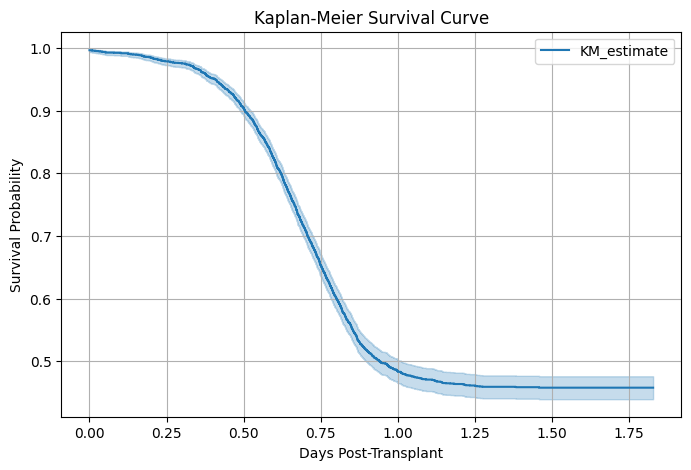

In [68]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# These come from your test set
event_indicator = AA02_y_test["efs"].values.astype(bool)
event_time = AA02_y_test["efs_time"].values

# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(durations=event_time, event_observed=event_indicator)

# Plot
plt.figure(figsize=(8, 5))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Days Post-Transplant')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()
